## Device

In [1]:
GPU_NUMBER = 4
DEVICE = 'cpu' if GPU_NUMBER < 0 else 'cuda:{}'.format(GPU_NUMBER)

In [2]:
DEVICE

'cuda:4'

## Prepare inference module

In [3]:
import mmseg
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
import mmcv
import numpy as np
import matplotlib.pyplot as plt
import glob
from collections import namedtuple, Counter

## Data

In [4]:
data_index = 1

In [5]:
DATA_PATH = "/rd-temp/mohan/raw_cityscapes/leftImg8bit"
DATA_SPLIT_CFG = "val"

In [6]:
image_list = glob.glob("{}/{}/*/*.png".format(DATA_PATH, DATA_SPLIT_CFG))

In [7]:
len(image_list)

500

In [8]:
raw_image_path = image_list[data_index]
gt_image_path = raw_image_path.replace("leftImg8bit", "gtFine").replace(".png", "_color.png")

print("Raw Image: {}".format(raw_image_path))
print("GT Image: {}".format(gt_image_path))

Raw Image: /rd-temp/mohan/raw_cityscapes/leftImg8bit/val/frankfurt/frankfurt_000001_067474_leftImg8bit.png
GT Image: /rd-temp/mohan/raw_cityscapes/gtFine/val/frankfurt/frankfurt_000001_067474_gtFine_color.png


In [9]:
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [10]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [11]:
dict({label.color: (label.name, label.trainId) for label in labels})

{(0, 0, 0): ('static', 255),
 (111, 74, 0): ('dynamic', 255),
 (81, 0, 81): ('ground', 255),
 (128, 64, 128): ('road', 0),
 (244, 35, 232): ('sidewalk', 1),
 (250, 170, 160): ('parking', 255),
 (230, 150, 140): ('rail track', 255),
 (70, 70, 70): ('building', 2),
 (102, 102, 156): ('wall', 3),
 (190, 153, 153): ('fence', 4),
 (180, 165, 180): ('guard rail', 255),
 (150, 100, 100): ('bridge', 255),
 (150, 120, 90): ('tunnel', 255),
 (153, 153, 153): ('polegroup', 255),
 (250, 170, 30): ('traffic light', 6),
 (220, 220, 0): ('traffic sign', 7),
 (107, 142, 35): ('vegetation', 8),
 (152, 251, 152): ('terrain', 9),
 (70, 130, 180): ('sky', 10),
 (220, 20, 60): ('person', 11),
 (255, 0, 0): ('rider', 12),
 (0, 0, 142): ('license plate', -1),
 (0, 0, 70): ('truck', 14),
 (0, 60, 100): ('bus', 15),
 (0, 0, 90): ('caravan', 255),
 (0, 0, 110): ('trailer', 255),
 (0, 80, 100): ('train', 16),
 (0, 0, 230): ('motorcycle', 17),
 (119, 11, 32): ('bicycle', 18)}

## Inference

In [12]:
config_file = '../experiments/config_pspnet.py'
checkpoint_file = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# img_file = '../sample/demo.png'
img_file = raw_image_path

In [13]:
config = mmcv.Config.fromfile(config_file)
model = init_segmentor(config, checkpoint_file, device=DEVICE)

In [14]:
model.CLASSES

('road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle')

In [15]:
next(model.parameters()).device

device(type='cuda', index=4)

In [16]:
result = inference_segmentor(model, img_file)

In [17]:
result[0].shape

(1024, 2048)

In [18]:
Counter(result[0].reshape(-1))

Counter({2: 654459,
         10: 16124,
         8: 150577,
         5: 17735,
         7: 15442,
         6: 8806,
         13: 13303,
         11: 67713,
         15: 36462,
         17: 8909,
         0: 1035881,
         4: 10461,
         18: 8482,
         1: 52798})

## Show results
> Using API: `show_result_pyplot(model, img, result, model.PALETTE)`

The following codes are reproducing the `show_result_pyplot()` function to have more flexiblity to control the output.

In [19]:
img = mmcv.imread(img_file)
img = img.copy()
seg = result[0]

print("Image Shape: ", img.shape)
print("Segmentation Mask Shape: ", seg.shape)

Image Shape:  (1024, 2048, 3)
Segmentation Mask Shape:  (1024, 2048)


In [20]:
palette = np.array(model.PALETTE)

print("Palette Shape: ", palette.shape)

Palette Shape:  (19, 3)


In [21]:
assert palette.shape[0] == len(model.CLASSES)
assert palette.shape[1] == 3
assert len(palette.shape) == 2

In [22]:
color_seg = np.zeros(img.shape, dtype=np.uint8)

print("Color Segmentation Mask Shape: ", color_seg.shape)

Color Segmentation Mask Shape:  (1024, 2048, 3)


In [23]:
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
    
# convert to BGR (it is required to convert segmentation mask to BGR to match raw image channel order)
color_seg = color_seg[..., ::-1]

In [24]:
# Overlay segmentation mask on to original image
img_overlay = img * 0.5 + color_seg * 0.5
img_overlay = img_overlay.astype(np.uint8)

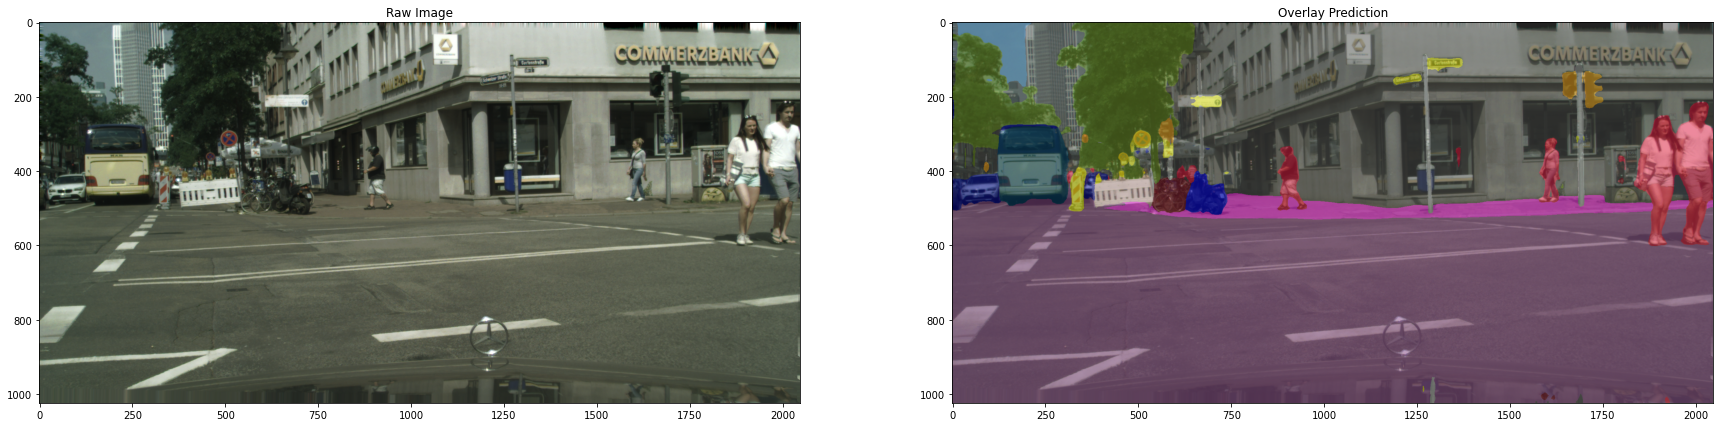

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.imshow(mmcv.bgr2rgb(img))
ax2.imshow(mmcv.bgr2rgb(img_overlay))

ax1.set_title("Raw Image")
ax2.set_title("Overlay Prediction")

plt.show()

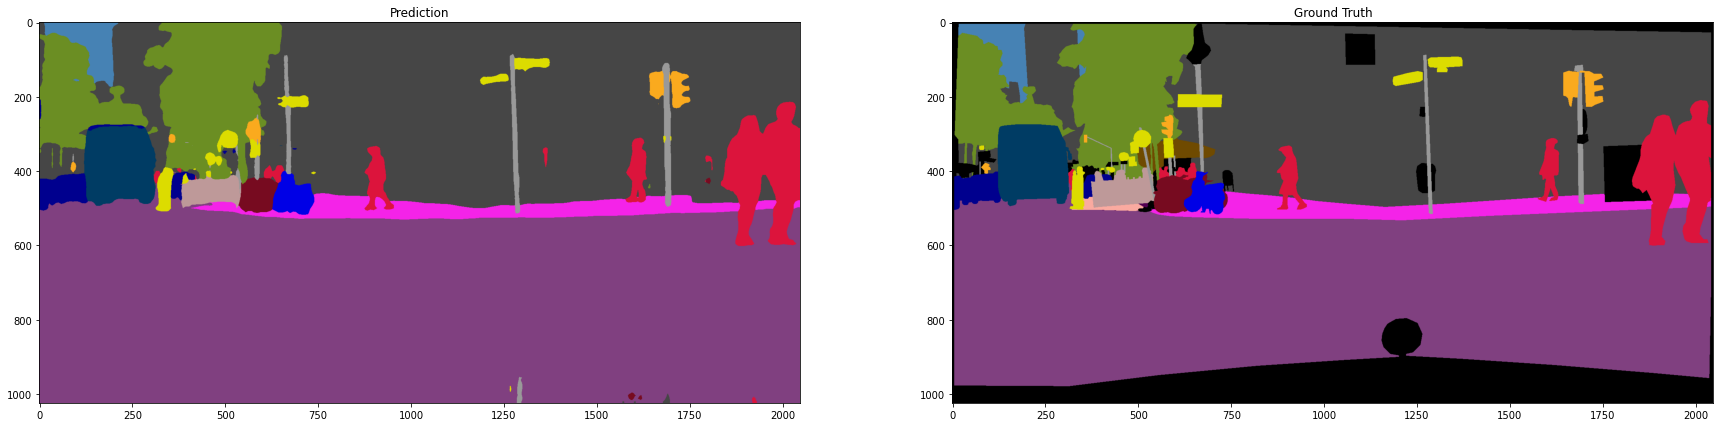

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.imshow(mmcv.bgr2rgb(color_seg))
ax2.imshow(mmcv.bgr2rgb(mmcv.imread(gt_image_path)))

ax1.set_title("Prediction")
ax2.set_title("Ground Truth")

plt.show()

In [27]:
def _show_class_seg(index_):
    color_seg_part = np.zeros(img.shape, dtype=np.uint8)

    color_seg_part[seg == index_, :] = model.PALETTE[index_] 
    color_seg_part = color_seg_part[..., ::-1]

    plt.figure(figsize=(15, 10))
    plt.imshow(mmcv.bgr2rgb(color_seg_part))
    plt.title(model.CLASSES[index_])
    plt.show()

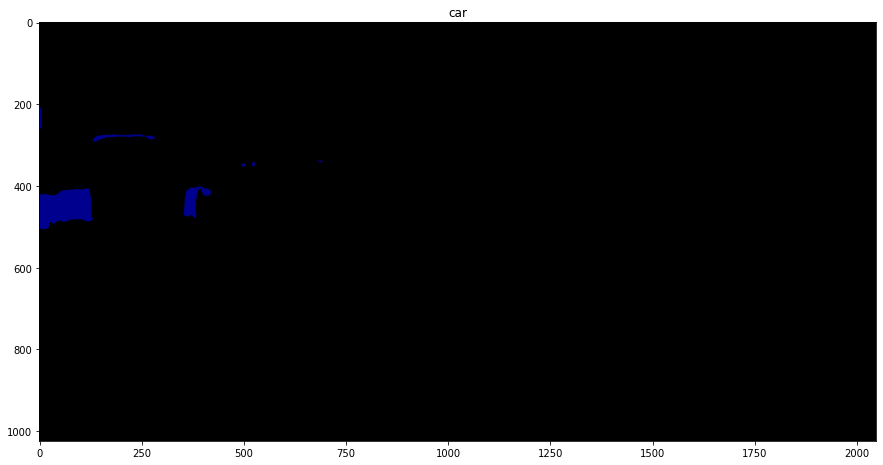

In [28]:
_show_class_seg(13)

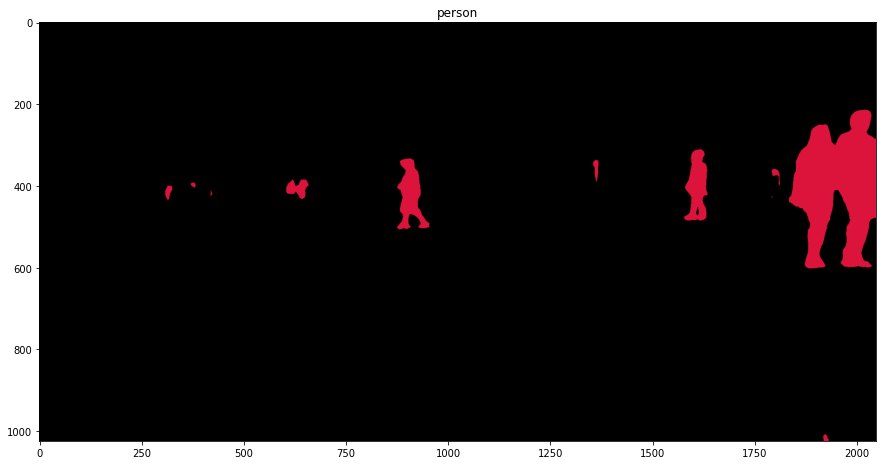

In [29]:
_show_class_seg(11)

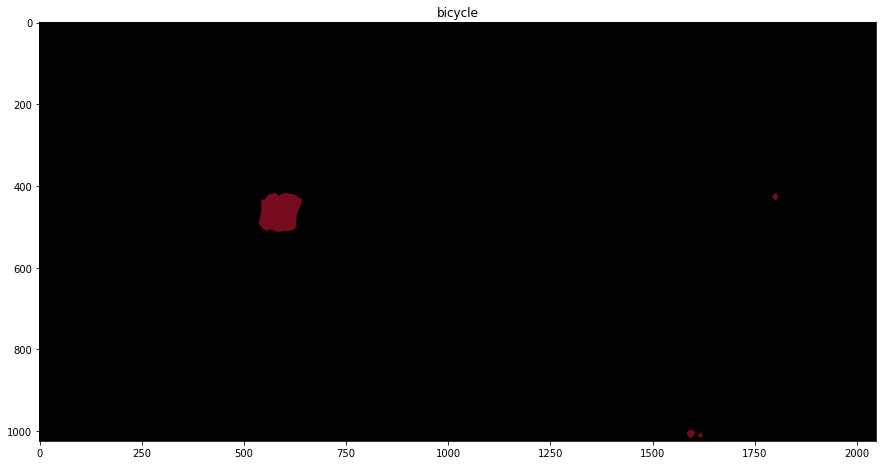

In [30]:
_show_class_seg(18)

## Calculate mIoU

- [x] Reproduce GT image
- [x] Reproduce mIoU with theoretical defination
    - [x] figure out `ignore_index` field
- [x] Check other data structure (polygon, labelsId, instanceId)

### Play with grouth data path with `color`

In [31]:
gt_truth_image = mmcv.bgr2rgb(mmcv.imread(gt_image_path))

In [32]:
gt_truth_image.shape

(1024, 2048, 3)

In [33]:
label_color_dict = dict({label.color: (label.name, label.trainId) for label in labels})

In [34]:
%%time
unique_rgb = []
for i in range(gt_truth_image.shape[0]):
    for j in range(gt_truth_image.shape[1]):
        gt_rgb_str = ",".join(map(lambda x: str(x), gt_truth_image[i][j]))
        if gt_rgb_str not in unique_rgb:
            unique_rgb.append(gt_rgb_str)

CPU times: user 6.71 s, sys: 5.46 ms, total: 6.72 s
Wall time: 6.73 s


In [35]:
gt_colors = [tuple(map(lambda x: int(x), v.split(","))) for v in unique_rgb]

In [36]:
for c in gt_colors:
    if c in label_color_dict:
        print(c, label_color_dict[c])
    else:
        print("No dict for : {}".format(str(c)))

(0, 0, 0) ('static', 255)
(70, 130, 180) ('sky', 10)
(70, 70, 70) ('building', 2)
(107, 142, 35) ('vegetation', 8)
(153, 153, 153) ('polegroup', 255)
(220, 220, 0) ('traffic sign', 7)
(250, 170, 30) ('traffic light', 6)
(220, 20, 60) ('person', 11)
(0, 60, 100) ('bus', 15)
(111, 74, 0) ('dynamic', 255)
(190, 153, 153) ('fence', 4)
(0, 0, 230) ('motorcycle', 17)
(0, 0, 142) ('license plate', -1)
(119, 11, 32) ('bicycle', 18)
(128, 64, 128) ('road', 0)
(244, 35, 232) ('sidewalk', 1)
(250, 170, 160) ('parking', 255)
(81, 0, 81) ('ground', 255)


### Play with grouth data path with `labelIds`

In [37]:
label_id_array_raw = mmcv.imread("/rd-temp/mohan/raw_cityscapes/gtFine/val/frankfurt/frankfurt_000001_067474_gtFine_labelIds.png")
label_id_array_converted = np.zeros(label_id_array_raw.shape)

In [38]:
id_rgb_dict = dict({label.id: [label.color[0], label.color[1], label.color[2]] for label in labels})

In [39]:
id_rgb_dict

{0: [0, 0, 0],
 1: [0, 0, 0],
 2: [0, 0, 0],
 3: [0, 0, 0],
 4: [0, 0, 0],
 5: [111, 74, 0],
 6: [81, 0, 81],
 7: [128, 64, 128],
 8: [244, 35, 232],
 9: [250, 170, 160],
 10: [230, 150, 140],
 11: [70, 70, 70],
 12: [102, 102, 156],
 13: [190, 153, 153],
 14: [180, 165, 180],
 15: [150, 100, 100],
 16: [150, 120, 90],
 17: [153, 153, 153],
 18: [153, 153, 153],
 19: [250, 170, 30],
 20: [220, 220, 0],
 21: [107, 142, 35],
 22: [152, 251, 152],
 23: [70, 130, 180],
 24: [220, 20, 60],
 25: [255, 0, 0],
 26: [0, 0, 142],
 27: [0, 0, 70],
 28: [0, 60, 100],
 29: [0, 0, 90],
 30: [0, 0, 110],
 31: [0, 80, 100],
 32: [0, 0, 230],
 33: [119, 11, 32],
 -1: [0, 0, 142]}

In [40]:
%%time
for i in range(label_id_array_converted.shape[0]):
    for j in range(label_id_array_converted.shape[1]):
        label_id_array_converted[i][j] = id_rgb_dict[label_id_array_raw[i][j][0]]

CPU times: user 6.4 s, sys: 28.9 ms, total: 6.43 s
Wall time: 6.44 s


In [41]:
(label_id_array_converted.astype(int) != mmcv.bgr2rgb(mmcv.imread(gt_image_path))).sum()

0

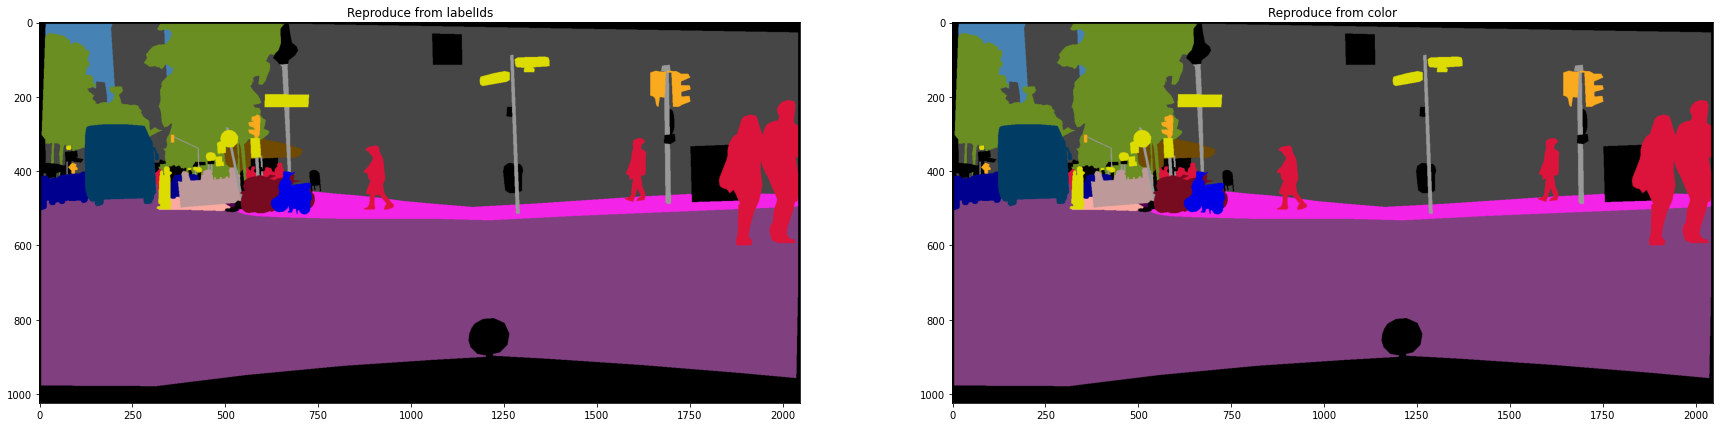

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.imshow(label_id_array_converted.astype(int))
ax2.imshow(mmcv.bgr2rgb(mmcv.imread(gt_image_path)))

ax1.set_title("Reproduce from labelIds")
ax2.set_title("Reproduce from color")

plt.show()

### Play with Json file

- *TODO*

#### Conclusion:
    
- Using the previous steps: we can match the annotation results between ones from `_color.png` and ones from `_labelIds.png`

### Match GT format with seg prediction results for metrics evaluation

In [43]:
result[0].shape

(1024, 2048)

In [44]:
result[0]

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [45]:
gt_mask_array = np.zeros((label_id_array_raw.shape[0], label_id_array_raw.shape[1]))

In [46]:
%%time
for i in range(gt_mask_array.shape[0]):
    for j in range(gt_mask_array.shape[1]):
        gt_mask_array[i][j] = label_id_array_raw[i][j][0]

CPU times: user 1.5 s, sys: 4.67 ms, total: 1.51 s
Wall time: 1.51 s


In [47]:
gt_mask_array.astype(int)

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [48]:
label_map = dict({label.id: label.trainId for label in labels})

In [49]:
Counter(gt_mask_array.astype(int).reshape(-1))

Counter({3: 31634,
         2: 74098,
         23: 16860,
         11: 577450,
         21: 144708,
         4: 39763,
         17: 14552,
         20: 17885,
         19: 8571,
         24: 64977,
         28: 37463,
         5: 6894,
         13: 12714,
         32: 7933,
         26: 10847,
         33: 9291,
         7: 845286,
         8: 52368,
         9: 2534,
         6: 228,
         1: 121096})

In [50]:
Counter(result[0].reshape(-1))

Counter({2: 654459,
         10: 16124,
         8: 150577,
         5: 17735,
         7: 15442,
         6: 8806,
         13: 13303,
         11: 67713,
         15: 36462,
         17: 8909,
         0: 1035881,
         4: 10461,
         18: 8482,
         1: 52798})

In [51]:
all_acc, ave_acc, ave_iou = mmseg.core.evaluation.mean_iou(
    results=result, 
    gt_seg_maps=[gt_mask_array.astype(int)], 
    num_classes=19, 
    ignore_index=255,
    label_map=label_map
)

/data-non-pii-share/rd_ai/mohan/anaconda3/envs/open-mmlab-2/lib/python3.7/site-packages/mmseg/core/evaluation/metrics.py:215: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/data-non-pii-share/rd_ai/mohan/anaconda3/envs/open-mmlab-2/lib/python3.7/site-packages/mmseg/core/evaluation/metrics.py:219: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


**NOTE**: we found label `license_plate` (id label `-1`) color palette is the same as `car`. We can convert all labels to `255` and ignore but here lets just convert them to `13` and compare with `car` predictions.

In [52]:
all_acc

0.9767582603156123

In [53]:
ave_acc

array([0.99460538, 0.90370073, 0.98692354,        nan, 0.78582665,
       0.8317757 , 0.85614281, 0.73502935, 0.96878542,        nan,
       0.87479241, 0.95503024,        nan, 0.94496174,        nan,
       0.95128527,        nan, 0.96092273, 0.81250673])

In [54]:
ave_iou

array([0.99249894, 0.84757146, 0.95877544,        nan, 0.76729898,
       0.68061179, 0.73145933, 0.676931  , 0.93603568,        nan,
       0.85774935, 0.90036563,        nan, 0.79915796,        nan,
       0.93142021,        nan, 0.8284969 , 0.79689644])

#### Break Down mIoU evaluation functions

In [55]:
# ground truth label
label = mmcv.imread(gt_mask_array.astype(int), flag='unchanged', backend='pillow')

In [56]:
Counter(label.reshape(-1))

Counter({3: 31634,
         2: 74098,
         23: 16860,
         11: 577450,
         21: 144708,
         4: 39763,
         17: 14552,
         20: 17885,
         19: 8571,
         24: 64977,
         28: 37463,
         5: 6894,
         13: 12714,
         32: 7933,
         26: 10847,
         33: 9291,
         7: 845286,
         8: 52368,
         9: 2534,
         6: 228,
         1: 121096})

In [57]:
# convert label id `-1` to `255` and ignore later
for old_id, new_id in label_map.items():
    label[label == old_id] = new_id

In [58]:
Counter(label.reshape(-1))

Counter({255: 276247,
         10: 16860,
         2: 577450,
         8: 144708,
         5: 14552,
         7: 17885,
         6: 8571,
         11: 64977,
         15: 37463,
         4: 12714,
         17: 7933,
         13: 10847,
         18: 9291,
         0: 845286,
         1: 52368})

In [59]:
# ignore pixels labeld as 255
mask = (label != 255)

In [60]:
# show percentage of pixels going to be evaluated
mask.mean()

0.8682751655578613

In [61]:
# mask pred label and gt label
pred_label = result[0].copy()
pred_label = pred_label[mask]

label = label[mask]

label.shape == pred_label.shape

True

In [62]:
Counter(label.reshape(-1))

Counter({10: 16860,
         2: 577450,
         8: 144708,
         5: 14552,
         7: 17885,
         6: 8571,
         11: 64977,
         15: 37463,
         4: 12714,
         17: 7933,
         13: 10847,
         18: 9291,
         0: 845286,
         1: 52368})

In [63]:
Counter(pred_label.reshape(-1))

Counter({10: 15084,
         2: 586852,
         8: 145254,
         5: 15336,
         7: 14681,
         6: 8799,
         11: 66000,
         13: 12229,
         15: 36437,
         17: 8891,
         4: 10298,
         18: 7731,
         0: 842520,
         1: 50793})

In [64]:
intersect = pred_label[pred_label == label]
intersect2 = label[pred_label == label]

In [65]:
(intersect != intersect2).sum()

0

In [66]:
num_classes = 19
area_intersect, _ = np.histogram(
    intersect, bins=np.arange(num_classes + 1))
area_pred_label, _ = np.histogram(
    pred_label, bins=np.arange(num_classes + 1))
area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
area_union = area_pred_label + area_label - area_intersect

In [67]:
area_intersect

array([840726,  47325, 569899,      0,   9991,  12104,   7338,  13146,
       140191,      0,  14749,  62055,      0,  10250,      0,  35638,
            0,   7623,   7549])

In [68]:
area_intersect.sum()

1778584

In [69]:
area_pred_label

array([842520,  50793, 586852,      0,  10298,  15336,   8799,  14681,
       145254,      0,  15084,  66000,      0,  12229,      0,  36437,
            0,   8891,   7731])

In [70]:
area_pred_label.sum()

1820905

In [71]:
area_label

array([845286,  52368, 577450,      0,  12714,  14552,   8571,  17885,
       144708,      0,  16860,  64977,      0,  10847,      0,  37463,
            0,   7933,   9291])

In [72]:
area_label.sum()

1820905

In [73]:
area_union

array([847080,  55836, 594403,      0,  13021,  17784,  10032,  19420,
       149771,      0,  17195,  68922,      0,  12826,      0,  38262,
            0,   9201,   9473])

In [74]:
# Test whether np.histogram() works align with our intuition
for i in range(19):
    if (intersect == i).sum() != area_intersect[i]:
        print("Conflicts here.")

In [75]:
for index_, (iou, c) in enumerate(zip(list(ave_iou), model.CLASSES)):
    print(index_, c, iou)

0 road 0.9924989375265618
1 sidewalk 0.8475714592735869
2 building 0.9587754435963479
3 wall nan
4 fence 0.7672989785730743
5 pole 0.6806117858749438
6 traffic light 0.7314593301435407
7 traffic sign 0.6769309989701339
8 vegetation 0.9360356811398736
9 terrain nan
10 sky 0.8577493457400407
11 person 0.9003656307129799
12 rider nan
13 car 0.7991579603929518
14 truck nan
15 bus 0.9314202080393079
16 train nan
17 motorcycle 0.8284969025105967
18 bicycle 0.7968964425208487


In [76]:
# Calculate mIoU
ave_iou[~np.isnan(ave_iou)].mean()

0.8360906503581992

#### Compare car prediction and ground truth

In [77]:
label_id_array_converted_car = np.zeros(label_id_array_raw.shape)

car_pixels = 0
for i in range(label_id_array_converted_car.shape[0]):
    for j in range(label_id_array_converted_car.shape[1]):
        if label_id_array_raw[i][j][0] == 26:
            label_id_array_converted_car[i][j] = id_rgb_dict[label_id_array_raw[i][j][0]]
            car_pixels += 1

In [78]:
car_pixels

10847

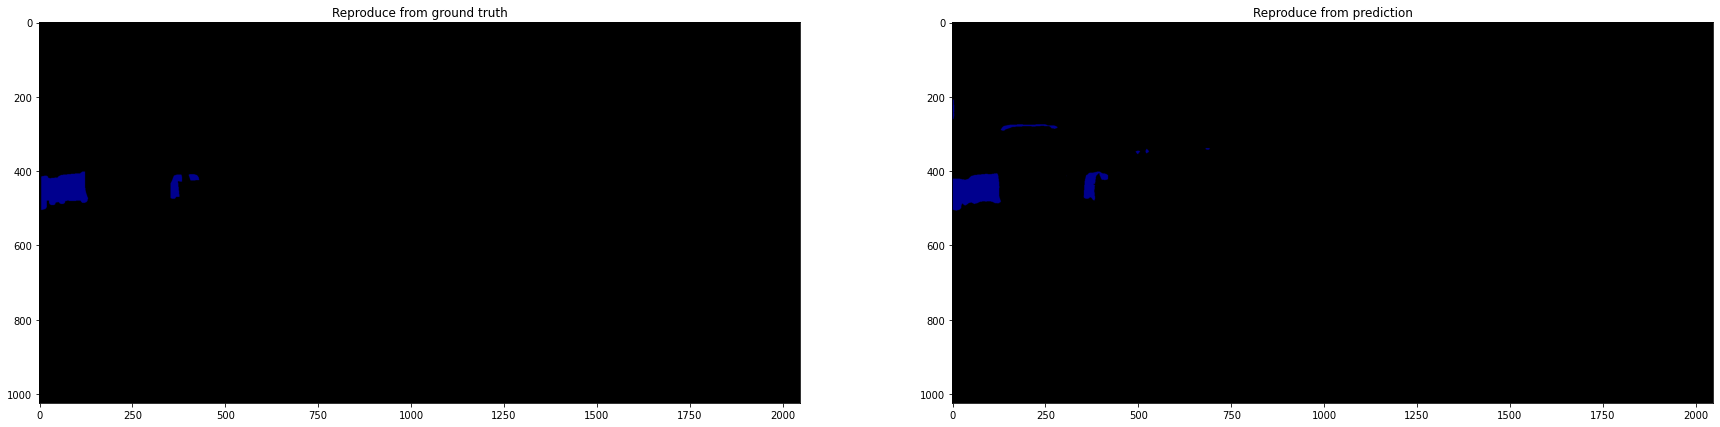

In [79]:
index_ = 13

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

color_seg_part_ = np.zeros(img.shape, dtype=np.uint8)

color_seg_part_[seg == index_, :] = model.PALETTE[index_] 
color_seg_part_ = color_seg_part_[..., ::-1]

ax1.imshow(label_id_array_converted_car.astype(int))
ax2.imshow(mmcv.bgr2rgb(color_seg_part_))

ax1.set_title("Reproduce from ground truth")
ax2.set_title("Reproduce from prediction")

plt.show()

#### Compare pole prediction and ground truth

In [80]:
label_id_array_converted_pole = np.zeros(label_id_array_raw.shape)

pole_pixels = 0
for i in range(label_id_array_converted_pole.shape[0]):
    for j in range(label_id_array_converted_pole.shape[1]):
        if label_id_array_raw[i][j][0] == 17:
            label_id_array_converted_pole[i][j] = id_rgb_dict[label_id_array_raw[i][j][0]]
            pole_pixels += 1

In [81]:
pole_pixels

14552

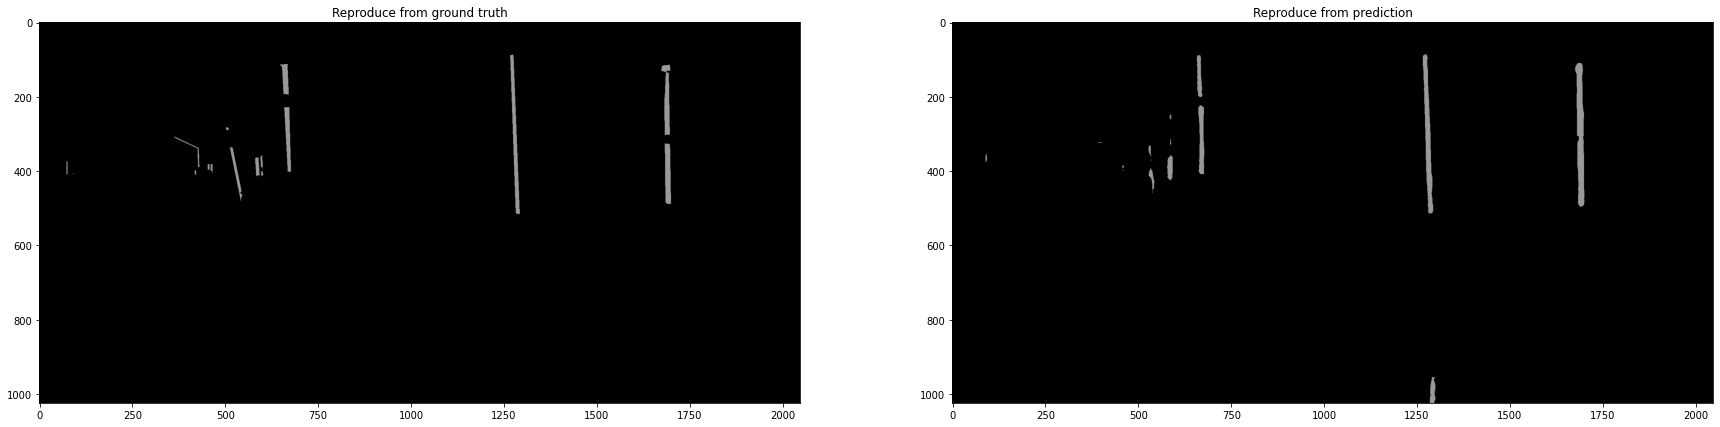

In [82]:
index_ = 5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

color_seg_part_ = np.zeros(img.shape, dtype=np.uint8)

color_seg_part_[seg == index_, :] = model.PALETTE[index_] 
color_seg_part_ = color_seg_part_[..., ::-1]


    
ax1.imshow(label_id_array_converted_pole.astype(int))
ax2.imshow(mmcv.bgr2rgb(color_seg_part_))

ax1.set_title("Reproduce from ground truth")
ax2.set_title("Reproduce from prediction")

plt.show()